## Visualizing Neuron Activation Map

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
import time
import cv2
import torch
import shap

sys.path.append('\\'.join(os.getcwd().split('\\')[:-1])+'\\src')
import utils as c_utils
import dataset as c_dataset
import explainers as c_explainers

from tqdm import tqdm
from torchvision import models
from torch import nn
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.manifold import TSNE

In [2]:
MODEL_PATH = '../model/MultiAugmentedSqueezeReduced.pth'

IMAGE_PATH = '../data/train_images'
DATA_PATH = '../data/multiData'
METADATA_PATH = '../data/multiData/test_data.csv'

INPUT_PATH = DATA_PATH + '/' + 'X_test.pth' 
LABEL_PATH = DATA_PATH + '/' + 'y_test.pth'
MASK_PATH  = DATA_PATH + '/' + 'M_test.pth'

In [3]:
n_classes = 5
class_labels = {0: 'No Defects', 1: 'Type 1', 2: 'Type 2', 3: 'Type 3', 4: 'Type 4'}

params = c_utils.get_default_params()
device = torch.device('cuda')
params

{'size': (64, 400),
 'mask_size': (64, 400),
 'mean': [0.485, 0.456, 0.406],
 'std': [0.229, 0.224, 0.225],
 'colors': [[0, 0.25, 0.25],
  [0.25, 0.0, 0.0],
  [0.0, 0.25, 0.0],
  [0.0, 0.0, 0.25]]}

In [4]:
### Check if the given paths exists
if DATA_PATH.split('/')[1] not in os.listdir(DATA_PATH.split('/')[0]): # Create folder if it does not exists
    os.mkdir(DATA_PATH) 
c1 = INPUT_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c2 = LABEL_PATH.split('/')[-1] in os.listdir(DATA_PATH)
c3 = MASK_PATH.split('/')[-1] in os.listdir(DATA_PATH)

In [5]:
### If the path are present we load the matrix, else we generate them
if c1 and c2 and c3:
    print('Data is present and ready to be loaded')
    X_val, y_val, M_val = torch.load(INPUT_PATH), torch.load(LABEL_PATH), torch.load(MASK_PATH)
else:
    print('Starting process to create matrices...')
    time.sleep(0.1)
    X_val, y_val, M_val = c_utils.create_data(IMAGE_PATH, METADATA_PATH, 
                                              batch_size=200, num_workers=0, 
                                              return_mask=True, params=params)

Data is present and ready to be loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


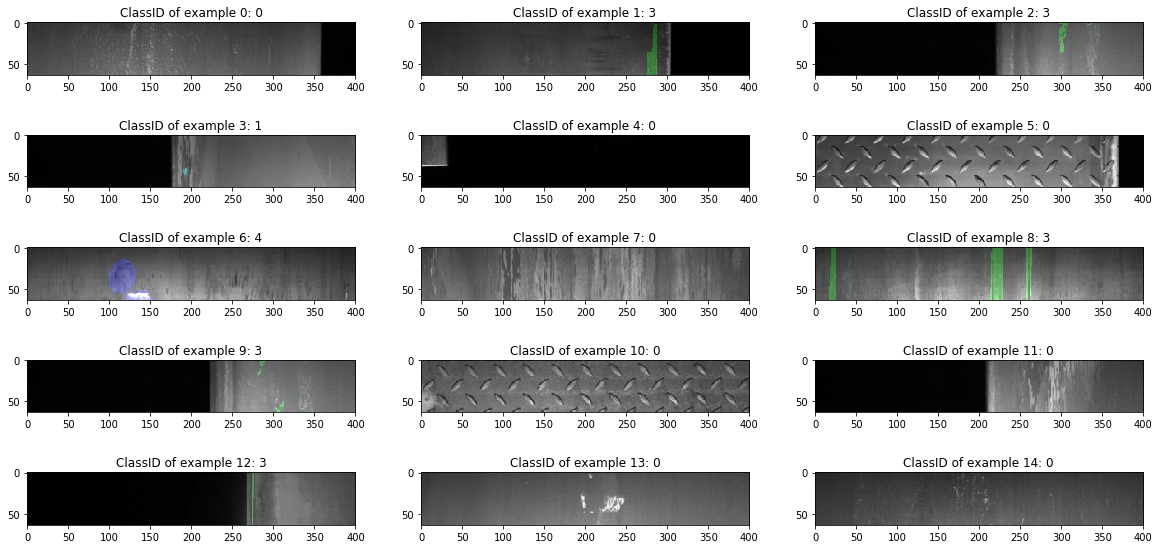

In [6]:
fig, ax = plt.subplots(5, 3, figsize=(20, 10))
start = 0
for i in range(start, start+15):
    img = np.transpose(X_val[i].numpy(), (1, 2, 0))*params['std'] + params['mean']
    mask = M_val[i].reshape(*params['size'])
    if y_val[i] != 0:
        img[mask == 1] = img[mask == 1] + params['colors'][y_val[i]-1]
    ax[(i-start)//3, (i-start)%3].set_title('ClassID of example {}: {}'.format(i, y_val[i]))
    ax[(i-start)//3, (i-start)%3].imshow(img)
plt.show()

In [7]:
### 4.1 Load architecture
net = models.squeezenet1_1(pretrained=True)
net.features = net.features[:10]
net.classifier[1] = nn.Conv2d(384, 1000, kernel_size = (1, 1), stride = (1, 1))
net.classifier = nn.Sequential(*net.classifier, nn.Flatten(), nn.Linear(1000, 5))#, nn.Softmax(dim=1))
net = net.to(device)
net.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [8]:
y_pred = []
y_true = []
y_score = torch.Tensor([])
batch_size = 5

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X, y = X_val[n*batch_size:(n+1)*batch_size].to(device), y_val[n*batch_size:(n+1)*batch_size].to(device).long()
        out = net(X)
        probs = out.detach().cpu()
        if type(net.classifier[-1]) != torch.nn.modules.activation.Softmax: 
            probs = nn.Softmax(dim=1)(out).detach().cpu()
        
        y_score = torch.cat([y_score, probs])
        y_pred = np.concatenate([y_pred, np.argmax(out.detach().cpu().numpy(), axis=1)])
        y_true = np.concatenate([y_true, y.cpu().numpy()])
        
y_score = y_score.numpy()
print('Accuracy: {:.4f}\tF1 Score: {:.4f}'.format(accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='macro')))

100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:08<00:00, 54.39it/s]

Accuracy: 0.9212	F1 Score: 0.8511


### Visualize Neuron Maps

In [9]:
modules = [
           list(net.children())[0][0], 
           list(net.children())[0][3].squeeze, list(net.children())[0][3].expand1x1, list(net.children())[0][3].expand3x3,
           list(net.children())[0][4].squeeze, list(net.children())[0][4].expand1x1, list(net.children())[0][4].expand3x3,
           list(net.children())[0][6].squeeze, list(net.children())[0][7].expand1x1, list(net.children())[0][6].expand3x3,
           list(net.children())[0][7].squeeze, list(net.children())[0][7].expand1x1, list(net.children())[0][7].expand3x3,
           list(net.children())[0][9].squeeze, list(net.children())[0][9].expand1x1, list(net.children())[0][9].expand3x3,
           list(net.children())[1][1]
          ]

mean = X_val.mean()
std = X_val.std()
project = (float(X_val.mean()-3*X_val.std()), float(X_val.mean()+3*X_val.std()))

Epoch 1: -1.0061417818069458	1.0061417818069458
Epoch 2: -1.0120166540145874	1.0120166540145874
Epoch 3: -1.0352531671524048	1.0352531671524048
Epoch 4: -1.0702629089355469	1.0702629089355469
Epoch 5: -1.1172279119491577	1.1172279119491577
Epoch 6: -1.1764508485794067	1.1764508485794067
Epoch 7: -1.24828040599823	1.24828040599823
Epoch 8: -1.3331820964813232	1.3331820964813232
Epoch 9: -1.4316211938858032	1.4316211938858032
Epoch 10: -1.5440173149108887	1.5440173149108887
Epoch 11: -1.670772910118103	1.670772910118103
Epoch 12: -1.8123936653137207	1.8123936653137207
Epoch 13: -1.9694230556488037	1.9694230556488037
Epoch 14: -2.1422533988952637	2.1422533988952637
Epoch 15: -2.331305503845215	2.331305503845215
Epoch 16: -2.536869764328003	2.536869764328003
Epoch 17: -2.7591612339019775	2.7591612339019775
Epoch 18: -2.9983086585998535	2.9983086585998535
Epoch 19: -3.2538368701934814	3.2538368701934814
Epoch 20: -3.525722026824951	3.525722026824951
Epoch 21: -3.813894748687744	3.8138947486

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


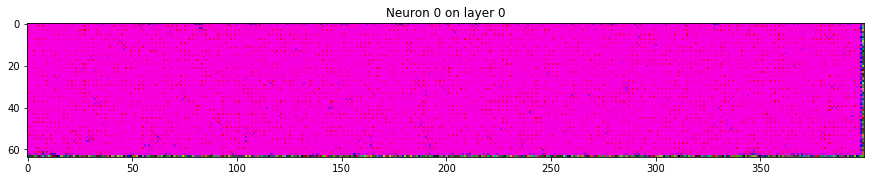

In [24]:
dim = (64, 400)
layer = 0
neuron = 0

detector = c_explainers.Detector(model=net, lr=30, loss_type=1)
inp = torch.randn(1, 3, dim[0], dim[1]).to(device)*std*1.2 + mean
#inp = X_val[0][:, :32, :32].unsqueeze(0).to(device)
loss, out, x = detector.detect(dim=dim, 
                               module=modules[layer], 
                               neuron=neuron,
                               max_epoch=100,
                               max_activation=800, 
                               warm_start = inp,
                               project = (float(mean-3*std), float(mean+3*std)),
                               debug = 0,
                               verbose = 1)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
img = np.transpose(x.detach().cpu().numpy().squeeze(0), (1, 2, 0))*params['std'] + params['mean']
ax.imshow(img)
ax.set_title('Neuron {} on layer {}'.format(neuron, layer))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


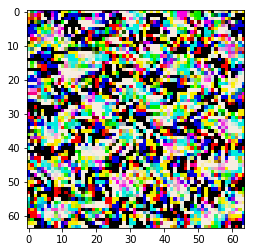

In [21]:
new_inp = img[:64, :64, :]
plt.imshow(new_inp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


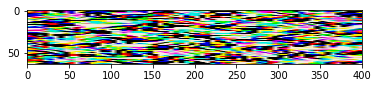

In [22]:
plt.imshow(cv2.resize(new_inp, (400, 64)))

Epoch 1: -48.44108200073242	48.44108200073242
Epoch 2: -50.662269592285156	50.662269592285156
Epoch 3: -54.315895080566406	54.315895080566406
Epoch 4: -58.822303771972656	58.822303771972656
Epoch 5: -63.7244758605957	63.7244758605957
Epoch 6: -68.73757934570312	68.73757934570312
Epoch 7: -73.83075714111328	73.83075714111328
Epoch 8: -79.0672378540039	79.0672378540039
Epoch 9: -84.49190521240234	84.49190521240234
Epoch 10: -90.17731475830078	90.17731475830078
Epoch 11: -96.2416000366211	96.2416000366211
Epoch 12: -102.66380310058594	102.66380310058594
Epoch 13: -109.37076568603516	109.37076568603516
Epoch 14: -116.15509033203125	116.15509033203125
Epoch 15: -123.04911041259766	123.04911041259766
Epoch 16: -130.0436248779297	130.0436248779297
Epoch 17: -137.11512756347656	137.11512756347656
Epoch 18: -144.23733520507812	144.23733520507812
Epoch 19: -151.41404724121094	151.41404724121094
Epoch 20: -158.74134826660156	158.74134826660156
Epoch 21: -166.0806427001953	166.0806427001953
Epoch 

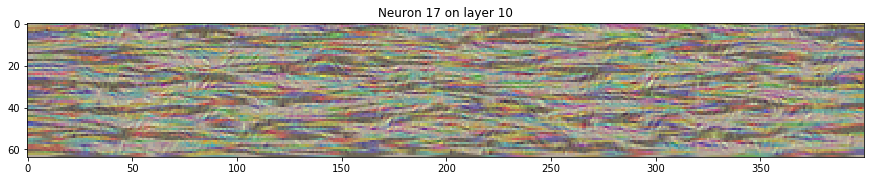

In [23]:
dim = (64, 400)
layer = 10
neuron = 17

detector = c_explainers.Detector(model=net, lr=0.1, loss_type=1)
inp = torch.tensor(np.transpose(cv2.resize(new_inp, (400, 64)), (2, 0, 1))).unsqueeze(0).to(device)
loss, out, x = detector.detect(dim=dim, 
                               module=modules[layer], 
                               neuron=neuron,
                               max_epoch=100,
                               max_activation=1000, 
                               warm_start = inp,
                               project = (float(mean-3*std), float(mean+3*std)),
                               debug = 0,
                               verbose = 1)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
img2 = np.transpose(x.detach().cpu().numpy().squeeze(0), (1, 2, 0))*params['std'] + params['mean']
ax.imshow(img2)
ax.set_title('Neuron {} on layer {}'.format(neuron, layer))
plt.show()

In [ ]:
module = modules[1]
xs, outs, neuron_number = torch.Tensor([]).to(device), [], []
for neuron in tqdm(range(module.out_channels)):
    dim = (64, 400)
    inp = torch.randn(1, 3, dim[0], dim[1]).to(device)*std*0.2 + mean
    loss, out, x = detector.detect(dim=dim, 
                                   module=module, 
                                   neuron=neuron,
                                   max_epoch=300,
                                   max_activation=200, 
                                   warm_start = inp,
                                   project = (float(mean-3*std), float(mean+3*std)),
                                   debug = 0,
                                   verbose = 0,
                                   tqdm_disable = True)
    xs = torch.cat([xs, x])
    outs.append(float(loss))

fig, ax = plt.subplots(xs.shape[0], 1, figsize=(20, xs.shape[0]*4))
for i in range(xs.shape[0]):
    n = i
    img = np.transpose(xs[n].detach().cpu().numpy(), (1, 2, 0))*params['std'] + params['mean']
    img = (img - img.min()) / (img.max() - img.min())
    ax[i].set_title('Img module and number {}/{}. Loss: {:.2f}'.format(n//16, n, outs[n]))
    ax[i].imshow(img)
plt.show()

### Check class discriminant neuron 

In [24]:
print(modules)

[Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2)), Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1)), Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1)), Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1)), Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1)), Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1)), Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1)), Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1)), Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1)), Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(256, 48, kernel_size=(1, 1), stride=(1, 1)), Conv2d(48, 192, kernel_size=(1, 1), stride=(1, 1)), Conv2d(48, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), Conv2d(384, 1000, kernel_size=(1, 1), stride=(1, 1))]


In [29]:
n = 16
hook = c_explainers.SaveFeatures(modules[n])                                                                     # When an input will be fed to the model, the SaveFeatures class will hook the output of out layer and store them in SaveFeatures.features.
X_0 = X_val[y_val == 0][:30].to(device)
X_1 = X_val[y_val == 1][:30].to(device)
X_2 = X_val[y_val == 2][:30].to(device)
X_3 = X_val[y_val == 3][:30].to(device)
X_4 = X_val[y_val == 4][:30].to(device)

### 2.Compute Loss and gradient
_ = net(X_0) # Feed the input to the model
output0 =  hook.features.cpu().detach()
_ = net(X_1)
output1 =  hook.features.cpu().detach()
_ = net(X_2) # Feed the input to the model
output2 =  hook.features.cpu().detach()
_ = net(X_4) # Feed the input to the model
output3 =  hook.features.cpu().detach()
_ = net(X_4) # Feed the input to the model
output4 =  hook.features.cpu().detach()

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 4.00 GiB total capacity; 1.29 GiB already allocated; 18.42 MiB free; 37.94 MiB cached)

25.648886 231


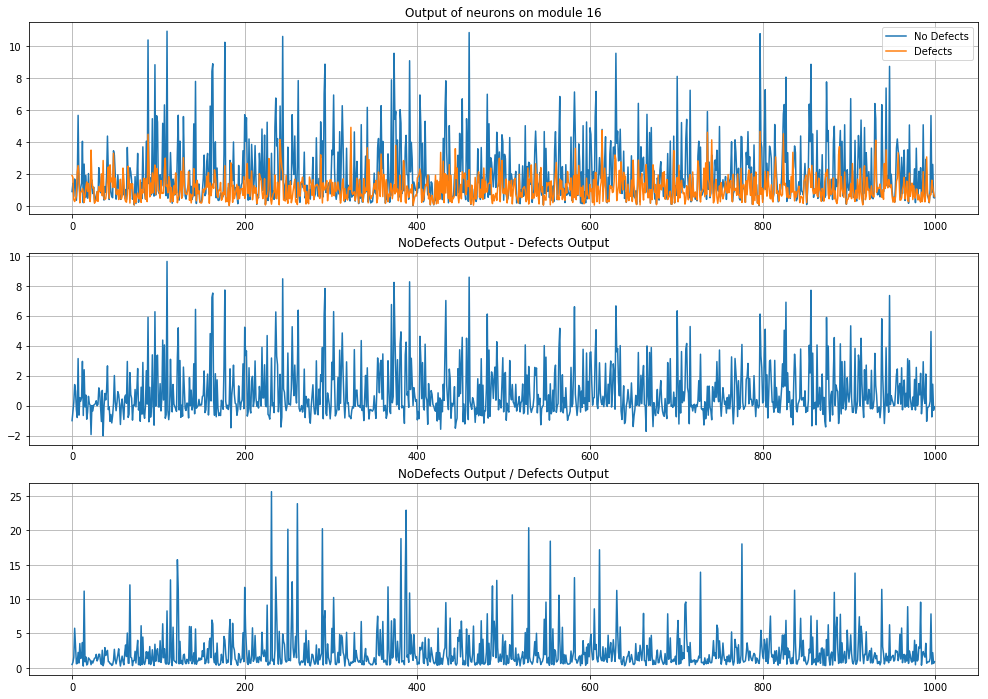

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(17, 12))

mean0 = output0.mean(axis=(0, 2, 3)).detach().cpu().numpy()
mean1 = output1.mean(axis=(0, 2, 3)).detach().cpu().numpy()
div = (mean0 + 0.02) / (mean1 + 0.02)
print(np.max(div), np.argmax(div))

ax[0].plot(mean0, label='No Defects')
ax[0].plot(mean1, label='Defects')
ax[0].legend()
ax[0].set_title('Output of neurons on module {}'.format(n))
ax[0].grid()
ax[1].set_title('NoDefects Output - Defects Output') 
ax[1].grid()
ax[1].plot(mean0 - mean1)
ax[2].set_title('NoDefects Output / Defects Output')
ax[2].grid()
ax[2].plot(div)
plt.show()

### T-SNE

In [134]:
tsne_X = torch.Tensor([]).to(device)

with torch.no_grad():
    net.eval()
    for n in tqdm(range(X_val.shape[0]//batch_size)):
        X = X_val[n*batch_size:(n+1)*batch_size].to(device)
        out = net.classifier[:-1](net.features(X))
        tsne_X = torch.cat([tsne_X, out])
tsne_X = tsne_X.detach().cpu().numpy()

100%|████████████████████████████████████████████████████████████████████████████████| 502/502 [00:06<00:00, 76.13it/s]


In [156]:
tsne_outs = []
perplexities = [2, 4, 8, 16, 32, 64]
for i in perplexities:
    tsne = TSNE(perplexity=i, n_jobs=-1)
    tsne_outs.append(tsne.fit_transform(tsne_X))

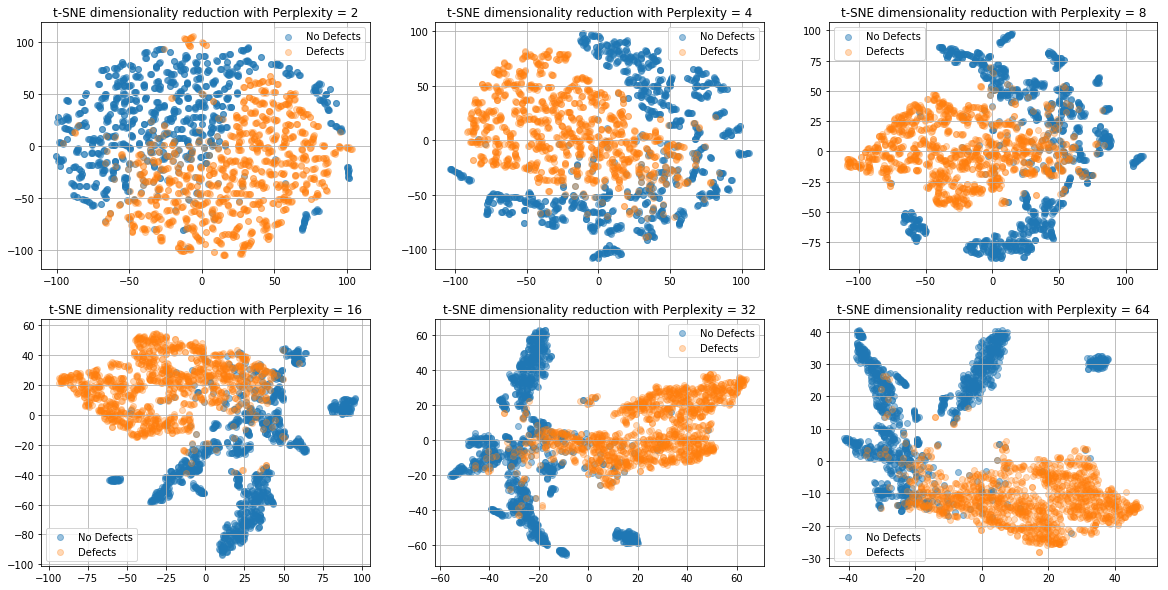

In [158]:
perplexities = [2, 4, 8, 16, 32, 64]
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(2):
    for j in range(3):
        n = i*3 + j
        ax[i, j].scatter(tsne_outs[n][:, 0][y_true == 0], tsne_outs[n][:, 1][y_true == 0], alpha=0.45, label='No Defects')
        ax[i, j].scatter(tsne_outs[n][:, 0][y_true == 1], tsne_outs[n][:, 1][y_true == 1], alpha=0.30, label='Defects')
        ax[i, j].legend()
        ax[i, j].set_title('t-SNE dimensionality reduction with Perplexity = {}'.format(perplexities[n]))
        ax[i, j].grid()
plt.show()